In [1]:
# Install the required libraries
#SAM
!pip3 install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip3 install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip3 install datasets
!pip3 install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip3 install patchify

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-temy0ds5
  Running command git clone -q https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-temy0ds5
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Get the data ready to train 

In [2]:
# imports

import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import patchify as patchify


# this function will be used to get an array of images from a folder

def read_images_to_array(folder_path):

  image_array = []
  # Get a sorted list of filenames
  filenames = sorted(os.listdir(folder_path))
  for filename in filenames:
    if filename.endswith(".jpg") or filename.endswith(".png"):
      img_path = os.path.join(folder_path, filename)
      img = cv2.imread(img_path)

      if img is not None:
        image_array.append(img)

  return image_array


## Sort, crop, and mask all the images

In [3]:
folder_path_images = './data/images (raw)'
image_array = read_images_to_array(folder_path_images)

# this is based on if the image has a white pixel at 25, 100
# ussually this seperates the two image types

red_region_data = []
raw_data = []

for image in image_array:
  if image[25, 100].sum() == 255 * 3:
    red_region_data.append(image)
  else:
    raw_data.append(image)

To test out if the function above works:

Text(0.5, 1.0, 'Raw Image')

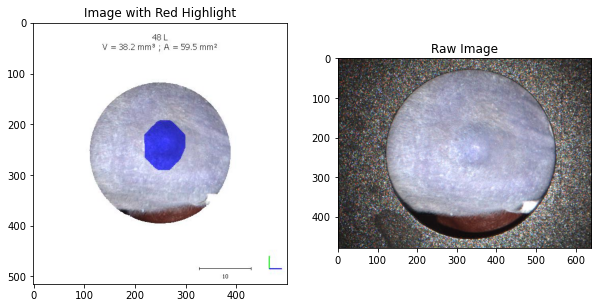

In [4]:
# picks a random image and displays it

rand = random.randint(0, len(red_region_data) - 1)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(red_region_data[rand])
ax[0].set_title('Image with Red Highlight')

ax[1].imshow(raw_data[rand])
ax[1].set_title('Raw Image')

In [5]:
# this crops out the noise from the raw images

raw_images_masked = []

# for loop

for i in range(len(raw_data) - 1):

  img = raw_data[i]

  mask = np.zeros(img.shape, dtype=np.uint8)
  mask = cv2.circle(mask, (320, 240), 200, (255,255,255), -1)

  res = cv2.bitwise_and(img, mask)
  res[mask==0] = 255

  raw_images_masked.append(res)

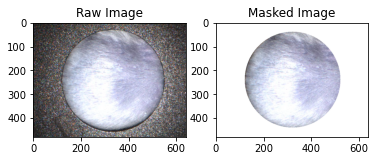

In [6]:
# picks a random number and displays it 

rand = random.randint(0, len(raw_images_masked) - 1)

fig, ax = plt.subplots(1,2)
ax[0].imshow(raw_data[rand])
ax[0].set_title("Raw Image")
ax[1].imshow(raw_images_masked[rand])
ax[1].set_title('Masked Image')

plt.show()

In [7]:
# this masks out the pictures that have the red region as well

red_region_circle_masks = []

# for loop

for i in range(len(red_region_data) - 1):

  img = red_region_data[i]

  mask = np.zeros(img.shape, dtype=np.uint8)
  mask = cv2.circle(mask, (250, 257), 135, (255,255,255), -1)

  res = cv2.bitwise_and(img, mask)
  res[mask==0] = 255

  red_region_circle_masks.append(res)

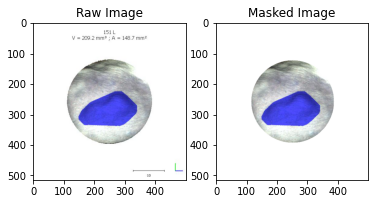

In [8]:
# picks a random image and displays it 

rand = random.randint(0, len(red_region_data) - 1)

fig, ax = plt.subplots(1,2)
ax[0].imshow(red_region_data[rand])
ax[0].set_title("Raw Image")
ax[1].imshow(red_region_circle_masks[rand])
ax[1].set_title('Masked Image')

plt.show()


In [9]:
# for loop to binary masks based off of the images with the red highlight

binary_masks = []

for image in red_region_circle_masks:

  hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

  lower_red = np.array([0,150,115])
  upper_red = np.array([255,255,255])


  mask = cv2.inRange(hsv, lower_red, upper_red)
  res = cv2.bitwise_and(image,image, mask= mask)


  binary_masks.append(mask)

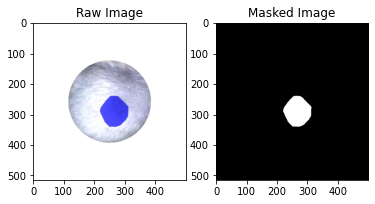

In [10]:
# picks a random image and displays it 

rand = random.randint(0, len(binary_masks) - 1)

fig, ax = plt.subplots(1,2)
ax[0].imshow(red_region_circle_masks[rand])
ax[0].set_title("Raw Image")
ax[1].imshow(binary_masks[rand], cmap = "gray")
ax[1].set_title('Masked Image')

plt.show()

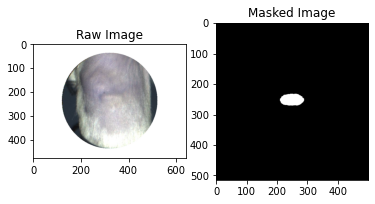

In [11]:
# displays the raw image and mask that we created side by side 
# they are not the same size so we have to fix that

rand = random.randint(0, len(binary_masks) - 1)

fig, ax = plt.subplots(1,2)
ax[0].imshow(raw_images_masked[rand])
ax[0].set_title("Raw Image")
ax[1].imshow(binary_masks[rand], cmap = "gray")
ax[1].set_title('Masked Image')

plt.show()

In [12]:
from PIL import Image
import numpy as np

resized_binary_masks = []
for mask in binary_masks:
  y=0
  x=0
  h=480
  w=640
  crop = mask[y:y+h, x:x+w]

  resized_binary_masks.append(crop)

# now that we have cropped the height, we have to add padding to the width

import cv2

padding = 70

padded_masks = []
for mask in resized_binary_masks:
  padded_img = cv2.copyMakeBorder(mask, 0, 0, padding, padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])
  padded_masks.append(padded_img)


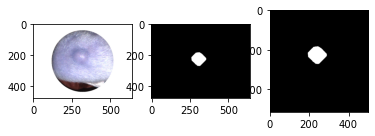

In [13]:
rand = random.randint(0, len(padded_masks) - 1)

fig, ax = plt.subplots(1,3)
ax[0].imshow(raw_images_masked[rand])
ax[1].imshow(padded_masks[rand], cmap = "gray")
ax[2].imshow(binary_masks[rand], cmap = "gray")

plt.show()

In [14]:
final_binary_masks = padded_masks

In [15]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

Now we have to resize the images in order to use them for training effectivly:

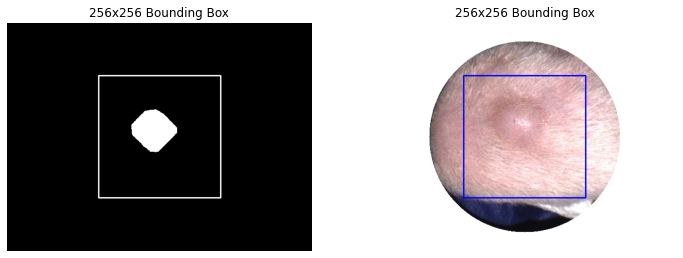

In [16]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

rand = random.randint(0, len(final_binary_masks) - 1)

# Get a random image
test_image_mask = final_binary_masks[rand]
test_image_raw = raw_images_masked[rand]

# Get the dimensions of the image
image_height, image_width = test_image_mask.shape[:2]

# Bounding box dimensions
box_width, box_height = 256, 256

# calculate the dimensions of the bounding box, based on the width and height of the orginal
x_top_left = (image_width - box_width) // 2
y_top_left = (image_height - box_height) // 2
x_bottom_right = x_top_left + box_width
y_bottom_right = y_top_left + box_height

# Draw the bounding box (blue color with thickness 2)
cv2.rectangle(test_image_mask, (x_top_left, y_top_left), (x_bottom_right, y_bottom_right), (255, 0, 0), 2)
cv2.rectangle(test_image_raw, (x_top_left, y_top_left), (x_bottom_right, y_bottom_right), (255, 0, 0), 2)

# Display the images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(cv2.cvtColor(test_image_mask, cv2.COLOR_BGR2RGB))
ax[0].set_title('256x256 Bounding Box')
ax[0].axis('off')

ax[1].imshow(cv2.cvtColor(test_image_raw, cv2.COLOR_BGR2RGB))
ax[1].set_title('256x256 Bounding Box')
ax[1].axis('off')

plt.show()


In [17]:
# now that we see that all the data can fit within 256x256
# we can write code that will crop out the images 

cropped_binary_arr = []
cropped_raw_arr = []

for i in range(len(final_binary_masks) - 1): 

    raw_image = raw_images_masked[i]
    binary_image = final_binary_masks[i]

    image_height, image_width = raw_image.shape[:2]

    # Bounding box dimensions
    box_width, box_height = 256, 256

    x_top_left = (image_width - box_width) // 2
    y_top_left = (image_height - box_height) // 2
    x_bottom_right = x_top_left + box_width
    y_bottom_right = y_top_left + box_height
    
    # Crop the images using array slicing
    cropped_binary = binary_image[y_top_left:y_bottom_right, x_top_left:x_bottom_right]
    cropped_raw = raw_image[y_top_left:y_bottom_right, x_top_left:x_bottom_right]

    cropped_binary_arr.append(cropped_binary)
    cropped_raw_arr.append(cropped_raw)

final_binary_masks = cropped_binary_arr
raw_images_masked = cropped_raw_arr


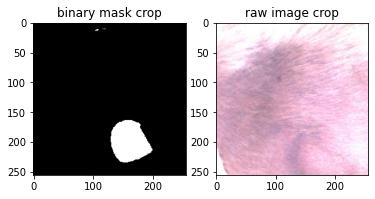

In [18]:
# test to see if the crop worked 

rand = random.randint(0, len(final_binary_masks) - 1) 

fig, ax = plt.subplots(1,2)

ax[0].imshow(final_binary_masks[rand], cmap = 'gray') 
ax[0].set_title('binary mask crop') 

ax[1].imshow(raw_images_masked[rand]) 
ax[1].set_title('raw image crop')

plt.show()


In [19]:
final_binary_masks.shape

AttributeError: 'list' object has no attribute 'shape'

In [20]:
raw_images_masked.shape

AttributeError: 'list' object has no attribute 'shape'

In [21]:
red_region_circle_masks = np.array(red_region_circle_masks)

red_region_circle_masks.shape

(196, 515, 500, 3)

In [22]:
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np

# this is to sample the augmented ones 
aug_raw = []
aug_masks = []

# Function to apply augmentation (flip and random rotation)
def augment_image(raw_image, binary_mask):
    
    # Flip the image horizontally
    flipped_raw_image = cv2.flip(raw_image, 1)
    flipped_binary_mask = cv2.flip(binary_mask, 1)
    
    # Randomly select a rotation angle between -30 and 30 degrees
    angle = random.uniform(-30, 30)
    (h, w) = flipped_raw_image.shape[:2]
    center = (w // 2, h // 2)

    # rotation
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    raw_image_augmented = cv2.warpAffine(flipped_raw_image, M, (w, h))
    binary_mask_augmented = cv2.warpAffine(flipped_binary_mask, M, (w, h))
    
    return raw_image_augmented, binary_mask_augmented

def augment_dataset(images, masks, augmentations_per_image=5):
    augmented_images = []
    augmented_masks = []
    
    for i in range(len(images)):
        image = images[i]
        mask = masks[i]
        
        for _ in range(augmentations_per_image):
            augmented_image = augment_image(image)
            augmented_mask = augment_image(mask)
            
            augmented_images.append(augmented_image)
            augmented_masks.append(augmented_mask)
    
    return augmented_images, augmented_masks

# for loop to augment all the images and add them 

raw_images_masked = list(raw_images_masked)
final_binary_masks = list(final_binary_masks)

for i in range(red_region_circle_masks.shape[0] - 1): 
    
    # get each image 
    binary_image = final_binary_masks[i]
    raw_image = raw_images_masked[i]
    
    # augment each image 
    aug_raw_image, aug_binary_image = augment_image(raw_image, binary_image)
    
    # add each iamage 
    raw_images_masked.append(aug_raw_image)
    final_binary_masks.append(aug_binary_image)
    
    # sample the augmented ones for testing 
    aug_raw.append(aug_raw_image)
    aug_masks.append(aug_binary_image)
    
raw_images_masked = np.array(raw_images_masked) 
final_binary_masks = np.array(final_binary_masks) 


In [23]:
# see how much its changed by

raw_images_masked.shape

(390, 256, 256, 3)

In [24]:
final_binary_masks.shape

(390, 256, 256)

Now to test if the augmentation function worked correctly 

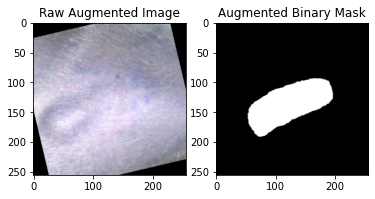

In [25]:
rand = random.randint(0, len(aug_raw)-1) 

fig, ax = plt.subplots(1,2) 

ax[0].imshow(aug_raw[rand])
ax[0].set_title("Raw Augmented Image") 

ax[1].imshow(aug_masks[rand], cmap="gray") 
ax[1].set_title("Augmented Binary Mask") 

plt.show()

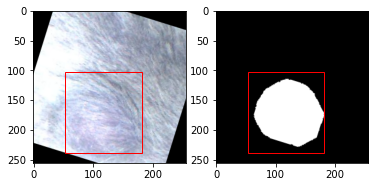

In [26]:
# test

import matplotlib.patches as patches # Import the patches module


rand = random.randint(0, len(final_binary_masks) - 1)

bbox1 = get_bounding_box(final_binary_masks[rand])

fig, ax = plt.subplots(1,2)
ax[0].imshow(raw_images_masked[rand])
ax[1].imshow(final_binary_masks[rand], cmap = "gray")

#
# Create a Rectangle patch
rect1 = patches.Rectangle((bbox1[0], bbox1[1]), bbox1[2] - bbox1[0], bbox1[3] - bbox1[1], linewidth=1, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((bbox1[0], bbox1[1]), bbox1[2] - bbox1[0], bbox1[3] - bbox1[1], linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax[0].add_patch(rect1)
ax[1].add_patch(rect2)

plt.show()

## Create the dataset

In [27]:
# now create a dataset with these images 

# convert lists to arrays
raw_images_masked = np.array(raw_images_masked)
final_binary_masks = np.array(final_binary_masks)

from datasets import Dataset
from PIL import Image
from datasets import DatasetDict, train_test_split

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in raw_images_masked],
    "label": [Image.fromarray(mask) for mask in final_binary_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

dataset_split = dataset.train_test_split(test_size=0.2)

# Access the train and validation datasets
train_dataset = dataset_split['train']
val_dataset = dataset_split['test']

final_binary_masks.shape

(390, 256, 256)

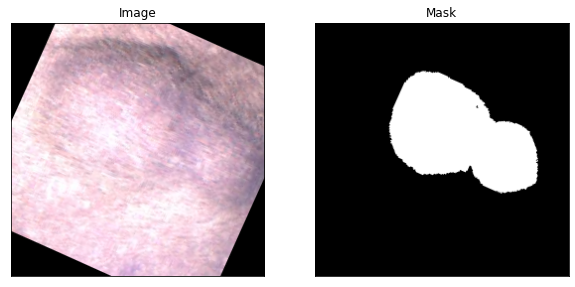

In [87]:
# now to check that everything is working 

img_num = random.randint(0, raw_images_masked.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [29]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

# Train the Model

In [30]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [83]:
from torch.utils.data import random_split, DataLoader

train_dataset = SAMDataset(dataset=dataset, processor=processor)
val_dataset = SAMDataset(dataset=val_dataset, processor=processor)


train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False) 


In [85]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [55]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([32, 3, 1024, 1024])
original_sizes torch.Size([32, 2])
reshaped_input_sizes torch.Size([32, 2])
input_boxes torch.Size([32, 1, 4])
ground_truth_mask torch.Size([32, 256, 256])


In [56]:
batch["ground_truth_mask"].shape

torch.Size([32, 256, 256])

In [57]:
batch["pixel_values"].shape

torch.Size([32, 3, 1024, 1024])

In [58]:
batch["input_boxes"].shape

torch.Size([32, 1, 4])

In [59]:
from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [60]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [66]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 100

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []

    # Training loop
    for batch in tqdm(train_dataloader):
        # Forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # Compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # Backward pass (compute gradients)
        optimizer.zero_grad()
        loss.backward()

        # Optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    # Logging training results
    print(f'EPOCH: {epoch}')
    print(f'Mean training loss: {mean(epoch_losses)}')

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_losses = []
    with torch.no_grad():  # Disable gradient computation
        for batch in tqdm(val_dataloader):
            # Forward pass
            outputs = model(pixel_values=batch["pixel_values"].to(device),
                            input_boxes=batch["input_boxes"].to(device),
                            multimask_output=False)

            # Compute loss
            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
            val_losses.append(loss.item())

    # Logging validation results
    print(f'Mean validation loss: {mean(val_losses)}')
    
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "./models/mito_model_checkpoint2.pth")



  0%|          | 0/10 [00:08<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 384.00 MiB. GPU 

# Test the model 

In [70]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [71]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("./models/mito_model_checkpoint.pth"))

<All keys matched successfully>

In [72]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

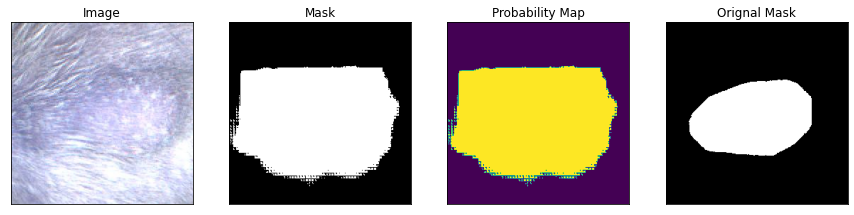

In [77]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, raw_images_masked.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")


axes[3].imshow(ground_truth_mask, cmap="gray")
axes[3].set_title('Orignal Mask')

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()
